# Interesting Papers

https://www.sciencedirect.com/science/article/pii/S0960077920303246?casa_token=g3PE29gmlPYAAAAA:Me4yIHdPkev1fSpsUuW0CkhVwXr4aH3cUHNkj__WwSZt6XGA1Nmk6wUEDMshkHyOCiLcwYY#sec0002

https://www.jstor.org/stable/4576118?seq=4

https://nzmj.org.nz/media/pages/journal/vol-131-no-1487/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years/ef4958102b-1696475878/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years.pdf

https://www.sciencedirect.com/science/article/pii/S1755436511000053

https://www.nber.org/system/files/working_papers/w27373/w27373.pdf

https://www.jstor.org/stable/4575511?seq=11

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
import numpy.typing as npt
from scipy.optimize import minimize
import numpy.typing as npt

In [100]:
from SEIRD_model_files import SEIRD_model 
from SEIRD_model_files import SEIRD_fitting
import importlib
importlib.reload(SEIRD_model)
importlib.reload(SEIRD_fitting)

<module 'SEIRD_model_files.SEIRD_fitting' from '/home/gavin/Documents/NZ_data/SEIRD_model_files/SEIRD_fitting.py'>

# Generalized multi-population SEIRD Model 

The number of susceptible $S$, infectious $I$, recovered $R$, and deceased (or non-interacting) $D$ for a given population group $g$ is stored in the Y matrix: $Y^{g}_{c}$, where $g$ is the population (stored in rows), and $c$ is the category ($S^g$, $E^g$, $I^g$, $R^g$ or $D^g$). Thus, in this case $Y$ is an $N$ by 5 matrix, where $N$ is the number of different populations. 

The $\theta$ matrix contains information about how the populations mix. It is an $N$ by $N$ matrix $\theta^i_g$, each element of which has the proportion of population group $g$ that spend that timestep in mixing environment $i$. It can also be thought of as the probability that a person from population $g$ will spend time in mixing environment $m$. $\sum_{m} \theta^m_g = 1$. 

$$ \sum_{g} \theta^m_g ~ Y^{g}_{c} = B^{m}_{c}, $$

where $B^m_c$ is an $M$ by 5 matrix of the number of people in mixing environment $m$ (e.g. young-people env, old folk env) that are of type $c$ (susceptible, exposed, infectious, recovered, or dead). 

The number of new infections in a particular group $g$ depends on their exposure to infectious people while visiting another population's environment, plus the exposure encountered by those who stayed. 

\begin{align}
\text{New Infections for those of type $g$ going to mixing environment }m &= \text{\# susceptible who go} \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
&= S^g\theta^m_g \times \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}}.
\end{align}

Thus, the total number of infections can be calculated:
\begin{align}
\text{New Infections for those in group }g &= \sum_{\text{places visited } m}\text{\# susceptible from $g$ who went to }m \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
\frac{\text{d}E_g}{\text{d}t} &= Y^g_S \sum_{m} \theta^m_g  \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}},\\
&=  Y^g_S\sum_{m}\theta^m_g\beta_m \frac{\sum_{g'}\theta^m_{g'} ~ Y^{g'}_{I}}{\sum_{g''}\sum_{c=S,E,I,R} \theta^m_{g''} ~ Y^{g''}_{c}}, \\
\end{align}

A deliberate choice is made here to removed the dead from the population. The logic here is that when folk visit somewhere, they are not mixing with the dead. Thus, dead folk do not reduce the propensity for infection --- they simply are removed from the overall population. However, the number of dead is so small this is probably a small perturbation. 



# Training the model on NZ data

We're going to do it with some ages, and the aim to get the $t \rightarrow \infty$ limit for the number of deaths equal to the total number of deaths of the age ranges and sexes.

But, for starters, we'll just train the simple SEIRD model on NZ data. 



In [73]:
NZ_death_data = pd.read_csv('SEIRD_model_files/deaths_by_age_and_date_and_military.csv').drop(columns=['Unnamed: 0'])
NZ_death_data.loc[:,'Total'] = NZ_death_data.loc[:,['0-19 military', 
                                                  '0-19 civilian', 
                                                  '20-49 military',
                                                  '20-49 civilian', 
                                                  '50+ military', 
                                                  '50+ civilian']].sum(axis=1)
NZ_death_data

,date_death,0-19 military,0-19 civilian,20-49 military,20-49 civilian,50+ military,50+ civilian,Total
0,1918-10-08 00:00:00,0,0,2,0,0,0,2
1,1918-10-09 00:00:00,0,0,1,0,0,0,1
2,1918-10-10 00:00:00,0,0,1,0,0,0,1
3,1918-10-11 00:00:00,0,0,4,1,0,0,5
4,1918-10-12 00:00:00,0,0,6,0,0,0,6
...,...,...,...,...,...,...,...,...
132,1919-02-22 00:00:00,0,0,2,0,0,0,2
133,1919-02-23 00:00:00,0,0,1,0,0,0,1
134,1919-02-24 00:00:00,0,0,2,0,0,0,2
135,1919-02-25 00:00:00,0,0,3,0,0,0,3


In [74]:
N_0_19 , N_20_49, N_50p, N_mil =  455502, 481145-46557, 161536, 46557  # from age census data 1916 and 1919 yearbook
N_T = N_0_19 + N_20_49 + N_50p + N_mil
print("From NZ census data 1916\n----------------------------\nNumber of 0 - 19:  {} ,\nNumber of 20 - 49: {} ,\nNumber of 50+:     {},\nNumber of mil:     {},\n     Total number :   {}".format(N_0_19, N_20_49, N_50p, N_mil, N_T))

From NZ census data 1916
----------------------------
Number of 0 - 19:  455502 ,
Number of 20 - 49: 434588 ,
Number of 50+:     161536,
Number of mil:     46557,
     Total number :   1098183


(Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Deaths per day'),
 <matplotlib.legend.Legend at 0x7f63c25e1090>)

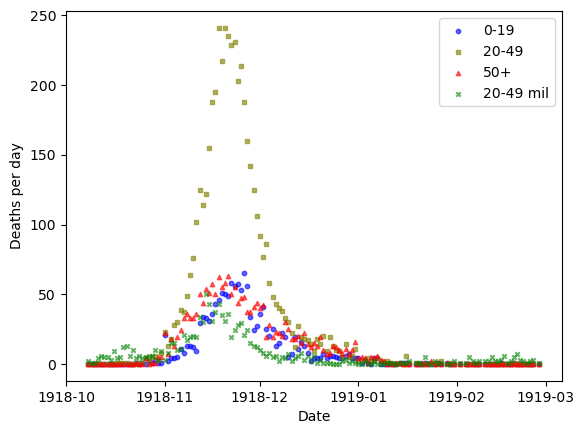

In [75]:
y_young = NZ_death_data.sort_values('date_death')['0-19 military'] + NZ_death_data.sort_values('date_death')['0-19 civilian']
y_mid   = NZ_death_data.sort_values('date_death')['20-49 civilian']
y_old   = NZ_death_data.sort_values('date_death')['50+ military'] + NZ_death_data.sort_values('date_death')['50+ civilian']
y_mil   = NZ_death_data.sort_values('date_death')['20-49 military']

y_data = np.array([y_young, y_mid, y_old, y_mil])

sigma_data = np.maximum(np.ones(y_data.shape),np.sqrt(y_data))

xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])
dummy = xplot
dummymin = min(xplot)
x_data = dummy.apply(lambda l: l - dummymin).dt.days

plt.scatter(xplot, y_young, color='blue', marker='o', label='0-19', alpha=.6, s=10)
plt.scatter(xplot, y_mid, color='olive', marker='s', label='20-49', alpha=.6, s=10)
plt.scatter(xplot, y_old, color='red', marker='^', label='50+', alpha=.6, s=10)
plt.scatter(xplot, y_mil, color='green', marker='x', label='20-49 mil', alpha=.6, s=10)
plt.xlabel('Date'), plt.ylabel('Deaths per day'), plt.legend()

# Fitting the data

In [85]:
class ModelHandler:
    """Class to communicate between fitting methods defined in SEIRD_fitting, and models defined in SEIRD_model.

    Should be changed each time dimensions of Y_0 are changed or the number of mixing environments is changed. 
    """
    def __init__(self,
                 seird_model,
                 date_of_first_infection,
                 dates,
                 Y_0):
        self.seird_model = seird_model
        self.date_of_first_infection = date_of_first_infection
        self.dates = dates
        self.fitting_params = self.get_fitting_params_from_model()
        self.Y_0 = Y_0

    def get_derivs_per_day(self):
        """Should rarely be a need to change"""
        return self.seird_model.compute_derivs_per_day(self.dates,
                                                       self.date_of_first_infection,
                                                       self.Y_0)
        
    def get_fitting_params_from_model(self):
        """Sets how fitting parameters are related to the model attributes.

        Should be altered each time a new number of parameters is set, e.g. changing the number of groups or mixing environments. 
        """
        return [self.date_of_first_infection,
                self.seird_model.beta_vector[0],
                self.seird_model.beta_vector[1],
                self.seird_model.gamma,
                self.seird_model.delta[0],
                self.seird_model.theta_matrix[0,0],
                self.seird_model.theta_matrix[0,1],
                self.seird_model.theta_matrix[0,2], 
                self.seird_model.theta_matrix[0,3]]
    
    def set_fitting_params_for_model(self, params):
        """Setting how the models parameters change.
        
        Should be altered each time a new number of parameters is changed, or the number of mixing environments, etc.
        """
        self.date_of_first_infection  = params[0]
        self.seird_model.beta_vector  = [params[1], params[2]]
        self.seird_model.gamma        = params[3]
        self.seird_model.delta        = params[4]*np.array([1.,1.,2.,1.])
        self.seird_model.theta_matrix = ModelHandler.build_theta_matrix(params[5], params[6], params[7], params[8])

    def print_params(self):
        print("Fitting parameters:\n")
        print("Date of first infection = {}".format(self.date_of_first_infection))
        print("beta_vector             = {}".format(self.seird_model.beta_vector))
        print("gamma                   = {}".format(self.seird_model.gamma))
        print("delta                   = {}".format(self.seird_model.delta))
        print("theta_matrix            =\n{}".format(self.seird_model.theta_matrix))
    
    @staticmethod
    def build_theta_matrix(*args) -> npt.NDArray:
        """Builds the theta matrix from a series of arguments. 
    
        Args:
          If first argument is 'Default', the args should be
          the parameters that go into the theta matrix.
          Otherwise args[0], then it should be a function to call and pass the rest of the arguments to. Can be an externally defined function, held as self.theta_matrix_building_method. 
    
        Returns:
          theta_matrix (npt.NDArray): 
            The matrix $\theta^i_g$ that couples population groups $g$ to mixing environments $i$. 
            Should be shape $M\times N$, where $M$ is the number of mixing environments and $N$ the number of pop groups. 
        """
        theta_matrix = np.array([[   args[0],    args[1], args[2], args[3]],
                                 [1.-args[0], 1.-args[1], 1.-args[2], 1.-args[3]]])
        return theta_matrix

In [294]:
Y_day_0_of_infection = np.array([[455502, 0, 0, 0, 0],
                                 [481145-46557, 0, 0, 0, 0],
                                 [161536, 0, 0, 0, 0],
                                 [46557-1, 0, 1, 0, 0]])

gamma_0, delta_0 = 0.45, 0.004*np.array([1.,1.,2., 1.])

beta_vector_0 = [1.2, 0.6]

latent_period = 1.4

theta_y1_0, theta_m1_0, theta_o1_0, theta_mil1_0 = 0.0001, 0.8, 0.0001, 0.98
theta_matrix_0 = ModelHandler.build_theta_matrix( theta_y1_0, theta_m1_0, theta_o1_0, theta_mil1_0)

day_of_first_infection_0 = -0

bounds=[(-30,10), (0.1,5.0), (0.0,1.5), (0.01,1.), (0.000, 0.1), (0.,1.), (0.,1.), (0.,1.), (0., 1.)]

In [267]:
my_model = SEIRD_model.SEIRD_model(beta_vector_0, gamma_0, delta_0, latent_period, theta_matrix_0)

my_model_handler = ModelHandler(my_model, # SEIRD_model object
                                day_of_first_infection_0, # day of first infection
                                x_data, # list of dates being used
                                Y_day_0_of_infection) # Y_0 

my_fit = SEIRD_fitting.fitting_deaths(x_data,
                                      y_data,
                                      sigma_y=sigma_data,
                                      seird_model=my_model,
                                      bounds=bounds,
                                      model_handler = my_model_handler)
my_fit.model_handler.print_params()

Fitting parameters:

Date of first infection = 0
beta_vector             = [1.2, 0.6]
gamma                   = 0.45
delta                   = [0.004 0.004 0.008 0.004]
theta_matrix            =
[[1.000e-04 8.000e-01 1.000e-04 9.800e-01]
 [9.999e-01 2.000e-01 9.999e-01 2.000e-02]]


Xi value = 16.250299500606854


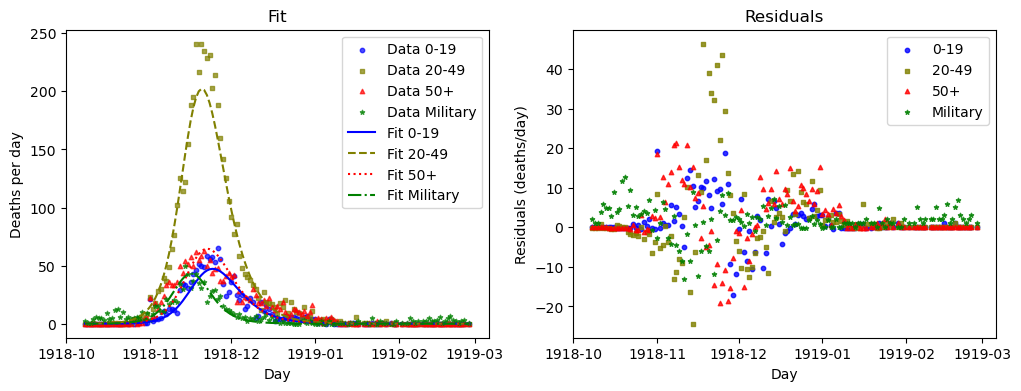

In [289]:
my_fit.plot_fit(labellist=['0-19','20-49','50+', 'Military'], xplot=xplot)

In [295]:
my_fit.bounds=bounds

In [296]:
%%time
my_fit.do_minimize(options={'maxiter':5000})
my_fit.opt

CPU times: user 1min 45s, sys: 90.8 ms, total: 1min 45s
Wall time: 1min 46s


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 16.163270624618523
             x: [-9.850e+00  4.538e+00  1.721e-01  3.892e-01  7.455e-03
                  2.504e-10  8.931e-02  2.017e-02  3.800e-01]
           nit: 2439
          nfev: 3766
 final_simplex: (array([[-9.850e+00,  4.538e+00, ...,  2.017e-02,
                         3.800e-01],
                       [-9.850e+00,  4.538e+00, ...,  2.017e-02,
                         3.800e-01],
                       ...,
                       [-9.850e+00,  4.538e+00, ...,  2.017e-02,
                         3.800e-01],
                       [-9.850e+00,  4.538e+00, ...,  2.017e-02,
                         3.800e-01]], shape=(10, 9)), array([ 1.616e+01,  1.616e+01,  1.616e+01,  1.616e+01,
                        1.616e+01,  1.616e+01,  1.616e+01,  1.616e+01,
                        1.616e+01,  1.616e+01]))

In [297]:
my_fit.model_handler.print_params()

Fitting parameters:

Date of first infection = -9.850194920425636
beta_vector             = [np.float64(4.53821689788832), np.float64(0.17210691849372461)]
gamma                   = 0.38923193639771203
delta                   = [0.00745465 0.00745465 0.01490929 0.00745465]
theta_matrix            =
[[2.50362920e-10 8.93078696e-02 2.01654053e-02 3.80019750e-01]
 [1.00000000e+00 9.10692130e-01 9.79834595e-01 6.19980250e-01]]


Xi value = 16.163270624618526


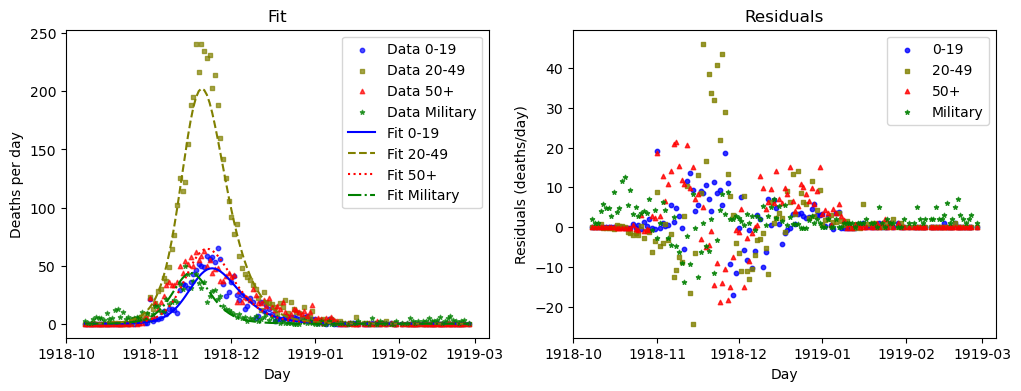

In [298]:
my_fit.plot_fit(labellist=['0-19','20-49','50+', 'Military'], xplot=xplot)
#plt.savefig('Deaths_age_and_mil.pdf')

Xi value = 16.163270624618526


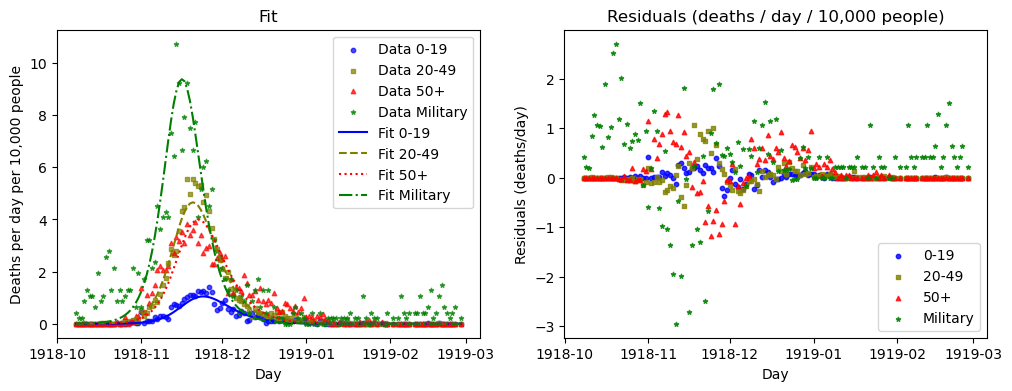

In [299]:
my_fit.plot_fit(labellist=['0-19','20-49','50+', 'Military'], xplot=xplot, plot_rate=True)
#plt.savefig('Death_rate_age_and_mil.pdf')

In [143]:
def multi_fit(fitting_object,
              list_of_initial_params,
              list_of_bounds):
    opt_list = []
    
    for i, (initial_params, bounds) in enumerate(zip(list_of_initial_params, list_of_bounds)):
        
        fitting_object.fitting_params = initial_params
        fitting_object.bounds = bounds

        fitting_object.do_minimize(options={'maxiter':5000}, tol=1e-10, method='Nelder-Mead')
        print("Completed optimization {} of {} with success: {}, and fun: {}".format(i+1, len(list_of_initial_params),fitting_object.opt.success, fitting_object.opt.fun))
        opt_list.append(fitting_object.opt)
    return opt_list

In [144]:
li = [[-9.210e+00,  1.0,  0.5,  5.752e-01,  9.695e-03,
                  4.113e-02,  2.414e-01,  8.261e-02 , 9.802e-01],
      [-10.0e+00,  0.9e+00,  0.3,  3.752e-01,  6.695e-03,
                  4.113e-02,  2.414e-01,  8.261e-02,  9.802e-01],
      [-9.210e+00,  0.8e+00,  0.6,  4.752e-01,  8.695e-03,
                  4.113e-02,  2.414e-01,  8.261e-02,  9.802e-01]]
lb = [[(-20,0), (0.1,1.3), (0.3,1.5), (0.01,1.), (0.000, 0.1), (0.,1.), (0.,1.), (0.,1.), (0., 1.)],
      [(-20,0), (0.1,1.0), (0.2,1.5), (0.01,1.), (0.000, 0.1), (0.,1.), (0.,1.), (0.,1.), (0., 1.)],
      [(-20,0), (0.4,1.5), (0.4,1.5), (0.01,1.), (0.000, 0.1), (0.,1.), (0.,1.), (0.,1.), (0., 1.)]]

In [145]:
opt_list = multi_fit(my_fit, li, lb)

Completed optimization 0 of 3 with success: True, and fun: 17.785737387164218
Completed optimization 1 of 3 with success: False, and fun: 47.149356273739926
Completed optimization 2 of 3 with success: True, and fun: 34.32284753513384


In [146]:
opt_list

[       message: Optimization terminated successfully.
        success: True
         status: 0
            fun: 17.785737387164218
              x: [-1.618e+01  1.300e+00  3.000e-01  4.808e-01  7.062e-03
                   0.000e+00  6.385e-01  1.009e-01  1.000e+00]
            nit: 4168
           nfev: 6091
  final_simplex: (array([[-1.618e+01,  1.300e+00, ...,  1.009e-01,
                          1.000e+00],
                        [-1.618e+01,  1.300e+00, ...,  1.009e-01,
                          1.000e+00],
                        ...,
                        [-1.618e+01,  1.300e+00, ...,  1.009e-01,
                          1.000e+00],
                        [-1.618e+01,  1.300e+00, ...,  1.009e-01,
                          1.000e+00]], shape=(10, 9)), array([ 1.779e+01,  1.779e+01,  1.779e+01,  1.779e+01,
                         1.779e+01,  1.779e+01,  1.779e+01,  1.779e+01,
                         1.779e+01,  1.779e+01])),
        message: Maximum number of iterations h